In [5]:
from typing import Dict

import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from scipy.stats import norm

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# *Causal Analysis* by Martin Huber (2023) || `Python code`


<br>
<img src="img/Bild Causal Analysis.JPG" width=150 align="center">

<br>


This is a **Jupyter Notebook** adaptation of [**Python code**](https://www.unifr.ch/appecon/en/assets/public/uploads/causal%20analysis%20-%20python%20examples.txt) for [**Causal Analysis**: Impact Evaluation and Causaal Machine Learning with Applications in R](https://amzn.to/3tCqu2z) by [Martin Huber](https://twitter.com/CausalHuber) (2023).

<br>

Adapted by [**Aleksander Molak**](https://alxndr.io) / [**CausalPython**](https://causalpython.io).

<a href="https://causalpython.io"><img src="img/CausalPython.io__flat.png" width=200 align="left"></a>



## Chapter 03
### Social Experiments and Linear Regression

#### Snippet 01

Simple ATE computation for RCT data

In [2]:
# load JC data
df = pd.read_csv('data/JC.csv')                                          

# Define the treatment (random assignment to JC)
D = df['assignment']

# Define the outcome (earnings in fourth year)
Y = df['earny4']

# Compute the ATE (assumed unconfoundedness)
Y[D==1].mean() - Y[D==0].mean() 

16.05512732009916

#### Snippet 02

Getting regression ATE estimate with heteroscedasticity-robust standard errors.

In [3]:
# Add constant to the data (to get an intercept estimate)
D = sm.add_constant(D)

# run OLS regression with White's heteroskedasticity robust se
ols = sm.OLS(Y, D).fit(cov_type='HC0')

# Results
print(ols.summary())   

                            OLS Regression Results                            
Dep. Variable:                 earny4   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     15.54
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           8.15e-05
Time:                        12:21:56   Log-Likelihood:                -61804.
No. Observations:                9240   AIC:                         1.236e+05
Df Residuals:                    9238   BIC:                         1.236e+05
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        197.9258      3.072     64.434      0.0

C:\Users\aleks\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### Snippet 03
Getting the ATE estimate with bootstrapping

In [45]:
# Define the bootstrapping function

def make_bootstraps(data: np.array, n_bootstraps: int=100) -> Dict[str, Dict[str, np.array]]:
    
    # Initilaize the dict
    dc = {}
    
    # Get sample size
    sample_size = data.shape[0]
    
    idx = [i for i in range(sample_size)]
    
    for b in tqdm(range(n_bootstraps)):
        
        # Get random indices
        sidx = np.random.choice(idx, replace=True, size=sample_size)
        
        # Select observations
        b_samp = data.loc[sidx, :]
        
        # Get indices of unused observations
        oob_idx = list(set(idx) - set(sidx))
        
        # Test sample array
        t_samp = np.array([])
        
        # If any unused observations -> add to test sample
        if oob_idx:
            t_samp = data.loc[oob_idx, :]
        
        # Add boot sample and test sample to the dict
        dc['boot_' + str(b)] = {'boot': b_samp, 'test': t_samp}  

    return(dc)

In [43]:
# Bootstrap the data
df_boot = make_bootstraps(df, 1999)

# Initialize arrays for coefficients & intercepts
coefs = np.array([])
intrs = np.array([])

# Initialize linear regression
lr = LinearRegression()

for b in tqdm(df_boot):
    
    # Fit the LR
    lr.fit(
        df_boot[b]['boot'].loc[:, 'assignment'].values.reshape(-1, 1),
        df_boot[b]['boot'].loc[:, 'earny4'].values.reshape(-1, 1)
    )
    
    # Add learned coefs and intercepts to the arrays
    coefs = np.concatenate([coefs, lr.coef_.flatten()])
    intrs = np.concatenate([intrs, lr.intercept_.flatten()])
    
# Print averaged intercept & coef
print(f'Mean intercept: {np.mean(intrs)}\n'
      f'Mean coeficient: {np.mean(coefs)}')

# Compute t-statistic
tstat = np.mean(coefs)/np.std(coefs)

# Compute p-value
p_val = 2*norm.cdf(-np.absolute(tstat))

#Print p-val and t-statistic
print(f'tstat: {tstat}\n'
      f'p_val: {p_val}')


100%|█████████████████████████████████████████████████████████████████████████████| 1999/1999 [00:04<00:00, 433.94it/s]

Mean intercept: 197.9412530998278
Mean coeficient: 15.87927493461315
tstat: 3.86222494911843
p_val: 0.00011235903441840408


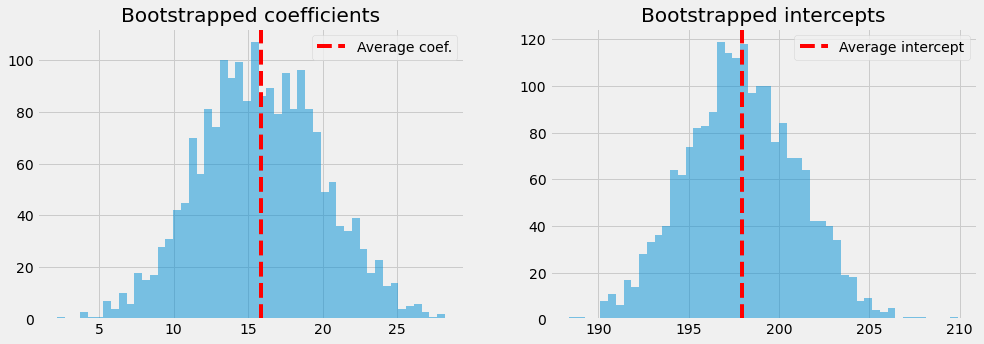

In [44]:
# Plot the distribution of bootstrapped coefs & intercepts
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.hist(coefs, bins=50, alpha=.5)
plt.axvline(coefs.mean(), label='Average coef.', c='red', ls='--')
plt.title('Bootstrapped coefficients')
plt.legend()

plt.subplot(122)
plt.hist(intrs, bins=50, alpha=.5)
plt.axvline(intrs.mean(), label='Average intercept', c='red', ls='--')
plt.title('Bootstrapped intercepts')
plt.legend()

plt.show()

#### Snippet 04

Two treatrments with *wexpect* data

In [46]:
# Read the data
df = pd.read_csv('data/wexpect.csv')

df.head()

,wexpect1,wexpect2,wexpect1othersex,wexpect2othersex,male,business,econ,communi,businform,plansfull,...,swiss,hassiblings,motherhighedu,fatherhighedu,motherworkedfull,motherworkedpart,matwellbeing,homeowner,treatmentinformation,treatmentorder
0,11.0,14.0,120.0,150,0,1,0,0,0,0,...,1,0,0,0,1,0,2.0,1,0,0
1,5.0,16.0,80.0,90,1,1,0,0,0,1,...,0,1,1,1,0,0,2.0,0,0,0
2,6.0,8.0,150.0,150,0,0,0,0,0,1,...,1,1,1,1,1,0,4.0,0,0,0
3,10.0,14.0,90.0,90,1,1,0,0,0,1,...,1,1,0,0,0,1,2.0,1,0,1
4,14.0,14.0,110.0,110,0,1,0,0,0,1,...,0,0,0,0,1,0,2.0,0,1,0


In [51]:
df.shape

(804, 39)

In [59]:
# Get the treatments
D = df [['treatmentinformation', 'treatmentorder']]

# Get the outcome
Y = df['wexpect2'] 

# Add constant
D = sm.add_constant(D) 

C:\Users\aleks\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [61]:
# White's heteroskedasticity robust OLS
ols = sm.OLS(Y, D).fit(cov_type = 'HC0')

# Summary
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:               wexpect2   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.198
Date:                Thu, 04 Jan 2024   Prob (F-statistic):              0.112
Time:                        14:12:17   Log-Likelihood:                -1966.9
No. Observations:                 804   AIC:                             3940.
Df Residuals:                     801   BIC:                             3954.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.4076 

#### Snippet 05
Continuous non-linear effect with *marketing* data

In [62]:
# Read in the data
df = pd.read_csv('data/marketing.csv')

df.head()

,youtube,facebook,newspaper,sales
0,276.12,45.36,83.04,26.52
1,53.40,47.16,54.12,12.48
2,20.64,55.08,83.16,11.16
3,181.80,49.56,70.20,22.20
4,216.96,12.96,70.08,15.48


In [68]:
# Get the treatment
D = df['newspaper']

# Get the outcome
Y = df['sales']

In [71]:
# Define the domain for kernal regression
x_axis = np.linspace(D.min(), D.max(), num=100)

# Fit the kernel regression & get results
results = sm.nonparametric.KernelReg(Y,D,'c', reg_type = 'lc').fit(x_axis)

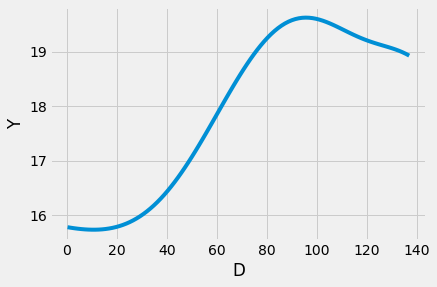

In [75]:
# Plot the results
plt.plot(x_axis, results[0])
plt.xlabel('D')
plt.ylabel('Y')
plt.show()

#### Snippet 06
Treatment with covariates on *coffeeleaflet* data.

In [77]:
# Read the data and drop NAs
df = pd.read_csv('data/coffeeleaflet.csv').dropna()

df.head()

,grade,sex,age,mob,bulgnationality,langbulg,mumage,mumedu,mumprof,dadage,...,awarepesticide,awaredeforestation,awarewastewater,awarebiodiversityloss,awareunfairworking,reusepurposeful,reusesoil,choiceprice,choicetastepleasure,choiceenvironsocial
0,10,1.0,16.0,11.0,1,1,42.0,2.0,2.0,44.0,...,3.0,1.0,3.0,1.0,1.0,1.0,1.0,6.0,6.0,6.0
1,9,1.0,15.0,5.0,1,1,38.0,2.0,4.0,44.0,...,3.0,2.0,3.0,1.0,2.0,2.0,3.0,2.0,5.0,1.0
2,10,1.0,15.0,12.0,1,1,42.0,2.0,7.0,45.0,...,1.0,2.0,1.0,3.0,4.0,1.0,1.0,6.0,6.0,6.0
3,9,1.0,15.0,4.0,1,1,40.0,3.0,7.0,43.0,...,1.0,2.0,3.0,4.0,3.0,2.0,1.0,6.0,6.0,6.0
4,12,0.0,18.0,6.0,1,1,44.0,2.0,1.0,44.0,...,1.0,3.0,1.0,4.0,1.0,1.0,1.0,1.0,4.0,3.0


In [78]:
# Get the treatment & predictors
V = df[
    [
        'treatment',
        'mumedu',
        'sex'
    ]
]

# Add constant
V = sm.add_constant(V)

# Get the outcome
Y = Y = df['awarewaste']

C:\Users\aleks\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [79]:
# Fit the model with White's heteroskedasticity robustness
ols = sm.OLS(Y, V).fit(cov_type='HC0')

# Results
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             awarewaste   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     4.450
Date:                Thu, 04 Jan 2024   Prob (F-statistic):            0.00447
Time:                        14:23:04   Log-Likelihood:                -435.12
No. Observations:                 299   AIC:                             878.2
Df Residuals:                     295   BIC:                             893.0
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2820      0.320      4.004      0.0